# Plate Examples

This notebook consists a limited set of examples to show the usage of Jones vectors in combination with our model.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

from control.matlab import unwrap

from mlmodel.system import MLsystem

### Phase shift

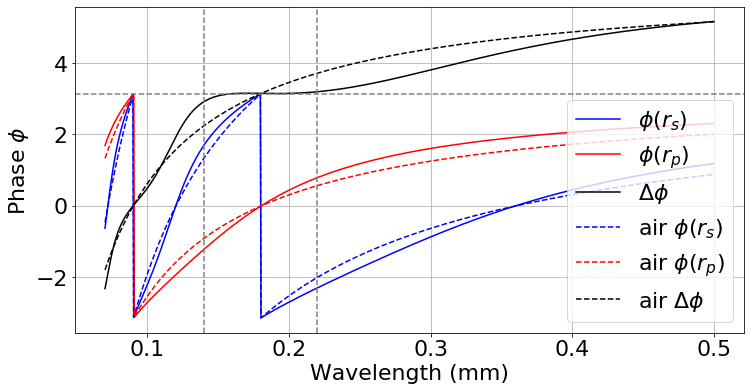

In [9]:
# Input
wave = np.linspace(0.07, 0.5, 1000) * 1e-3
freq = 3e8 / wave

# Initialize system surrounded by air with dielectric of 1
system = MLsystem(1)

# Add layers to the system one by one
system.add("layer", 0.314e-4, 2.05)
system.add("grid",  1e-6, 0.5e-6 / 2)
system.add("layer", 0.314e-4, 2.05)
system.add("shunt", 0.25)

# Initialize system surrounded by air with dielectric of 1
system2 = MLsystem(1)

# Add layers to the system one by one
system2.add("layer", 0.45e-4, 1)
system2.add("grid",  1e-6, 0.5e-6 /2)
system2.add("layer", 0.45e-4, 1)
system2.add("shunt", 0.25)

rs, ts = system.rt(0, freq, 's')
rp, tp = system.rt(0, freq, 'p')

rs2, ts2 = system2.rt(0, freq, 's')
rp2, tp2 = system2.rt(0, freq, 'p')

# Plot Reflectance
fig, frames = plt.subplots(1, 1, sharex=True, figsize=(12, 6))

unwrapped = unwrap((np.angle(rs)-np.angle(rp)).T[0]) 

frames.plot(wave * 1e3, np.angle(rs), label=r'$\phi(r_s)$', c='b')
frames.plot(wave * 1e3, np.angle(rp), label=r'$\phi(r_p)$', c='r')
frames.plot(wave * 1e3, unwrapped, label=r'$\Delta\phi$', c='black')

unwrapped = unwrap((np.angle(rs2)-np.angle(rp2)).T[0])

frames.plot(wave * 1e3, np.angle(rs2), label=r'air $\phi(r_s)$', c='b', ls='--')
frames.plot(wave * 1e3, np.angle(rp2), label=r'air $\phi(r_p)$', c='r', ls='--')
frames.plot(wave * 1e3, unwrapped, label=r'air $\Delta\phi$', c='black', ls='--')

for i in range(int(unwrapped.max()/np.pi)):
    frames.axhline((i + 1) * np.pi, ls='--', c='grey')

for l in [0.14, 0.22]:
    frames.axvline(l, ls='--', c='grey')

frames.legend(loc=4)
frames.set_xlabel("Wavelength (mm)")
frames.set_ylabel(r"Phase $\phi$")

frames.grid(True)
frames.ticklabel_format(useOffset=False)
plt.show()

### Absolute Reflections Plate

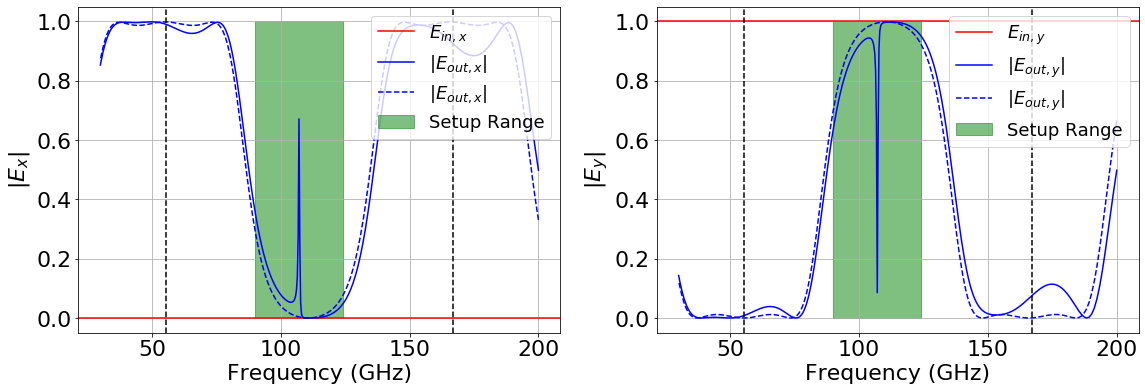

In [10]:
e = 2.94          # Dielectric Constant 
g = 0.474e-3      # Wire grid period
a = -45           # Rotation angle device

def rotationM(alpha):
    alpha = np.deg2rad(alpha)
    return np.array([[np.cos(alpha), np.sin(alpha)],
                     [-np.sin(alpha), np.cos(alpha)]])


def system(f, g):
    
    plate = MLsystem(1)
    plate.add("layer", 0.79e-3, e)
    plate.add("grid",  g, g / 4)
    plate.add("layer", 0.79e-3, e)
    plate.add("shunt", 0.25)
    
    # Run simulation
    r_s, t_s = plate.rt(0, f, 's')
    r_p, t_p = plate.rt(0, f, 'p')

    E_in = np.array([[0], [1]])

    # Rotation matrix
    rotM = rotationM(a)

    # Rotate to grid perspective
    E_in_grid = rotM @ E_in

    # Compute response in grid matrix
    E_out_grid = np.array([*r_s.T * E_in_grid[0],
                           *r_p.T * E_in_grid[1]])

    # Rotate to global system
    E_out_plate = np.linalg.inv(rotM) @ E_out_grid
    E_out = E_out_plate

    I_x = np.abs(E_out[0])**2 
    I_y = np.abs(E_out[1])**2 

    return I_x, I_y
    

# Input Parameters
wave = np.linspace(1.5, 10, 1000) * 1e-3    # mm
freq = 3e8 / wave

I_x, I_y = system(freq, g)       # Response self-made plate
I_x2, I_y2 = system(freq, 1e-6)  # Response with good grid

fig, frames = plt.subplots(1, 2, figsize=(19,6))
frames[1].axhline(1, c='r', label=r'$E_{in, y}$')
frames[1].plot(freq * 1e-9, I_y, c='b', label=r'|$E_{out, y}|$')
frames[1].plot(freq * 1e-9, I_y2, ls='--', c='b', label=r'|$E_{out, y}|$')
frames[0].axhline(0, c='r', label=r'$E_{in, x}$')
frames[0].plot(freq * 1e-9, I_x, c='b', label=r'|$E_{out, x}|$')
frames[0].plot(freq * 1e-9, I_x2, ls='--', c='b', label=r'|$E_{out, x}|$')

frames[0].set_ylabel(r'|$E_{x}|$')
frames[1].set_ylabel(r'|$E_{y}|$')

for frame in frames:
    frame.axvline(55.5, ls='--', c='black')
    frame.axvline(167, ls='--', c='black')
    frame.fill_between([90, 124], [1, 1], color='g', label='Setup Range', alpha=0.5)
    frame.set_xlabel("Frequency (GHz)")
    frame.grid()
    frame.legend(loc=1, fontsize=18)
plt.show()